In [1]:
#pip install scikeras

In [2]:
#pip install tensorflow

In [3]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os
import pandas as pd
from sklearn.model_selection import train_test_split

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

print("Done!")


Done!


In [4]:
df = pd.read_csv("emnist-letters.csv") #carica i dati in df

#separa le immagini dalle etichette e effettua reshaping in 28x28
X = df.iloc[:,1:].to_numpy().reshape(-1, 28, 28, order="F")
y = df.iloc[:,0].to_numpy()-1  # Sottrai 1 per avere etichette da 0 a 25

X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2) #random_state=42

#utilizziamo i primi 5000 campioni come validation set
X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.

print("Done!")

Done!


In [5]:
class_names = ["A", "B", "C", "D", "E", "F", "G", "H", "I", "J", "K", "L", "M", "N", "O", "P",
              "Q", "R", "S", "T", "U", "V", "W", "X", "Y", "Z",]

print("Done!")

Done!


build_model crea e configura un modello sequenziale utilizzando TensorFlow/Keras

In [6]:
def build_model (n_hidden=3, n_units=100, learning_rate=0.01):
    model = keras.models.Sequential() #Crea un modello sequenziale vuoto, a cui aggiungerai strati successivamente.
    model.add(keras.layers.Flatten(input_shape=[28, 28])) #layer di input
    for i in range(n_hidden): #crea i layer nascosti
        model.add(keras.layers.Dense(n_units, activation="relu"))
    model.add(keras.layers.Dense(26, activation="softmax")) #ultimo layer da utilizzare la f di attivazione softmax

    model.summary() #mi stampo il modello utilizzato in quel momento
    
    model.compile(loss="sparse_categorical_crossentropy", #loss utilizzata
              optimizer=keras.optimizers.SGD(lr=learning_rate), #ottimizzatore
              metrics=["accuracy"]) #metrica utilizzata
    return model

algoritmi di ricerca degli iperparametri

Durante la ricerca casuale degli iperparametri, verranno addestrati diversi modelli con combinazioni diverse di iperparametri e valutati tramite cross-validation. Il risultato finale sarà il modello con la combinazione ottimale di iperparametri secondo i criteri specificati durante la configurazione del RandomizedSearchCV.

In [7]:
from scipy.stats import reciprocal
import sklearn
from sklearn.model_selection import RandomizedSearchCV

#dizionario contenente alcune distribuzioni di parametri che possono
#essere utilizzate durante l'ottimizzazione dei parametri di un modello
param_distribs = {
    "n_hidden": [0, 1, 2, 3], #range di numeri di layer da provare
    "n_units": np.arange(1, 300).tolist(), #range delle unita
    "learning_rate": reciprocal(1e-3, 5e-2).rvs(1000).tolist(), #range del lr
}

# wrapper
from scikeras.wrappers import KerasClassifier

#creo un classificatore Keras utilizzando l'interfaccia di Scikit-learn.
keras_clf = KerasClassifier(
    model=build_model, #modello da utilizzare
    loss="sparse_categorical_crossentropy", #loss da utilizzare
    n_units=1, n_hidden=1, learning_rate=0.001 # necessary to assign a value here, to make them visible (and tunable) to scikit-learn
) #Questi valori iniziali sono necessari perché Scikit-learn richiede di assegnare dei valori a tutti i parametri del modello durante 
  #la creazione dell'istanza. Tuttavia, durante la ricerca degli iperparametri, questi valori potrebbero essere sovrascritti


#n_iter Specifica il numero di combinazioni di iperparametri diverse che verranno testate durante la ricerca casuale
#cv Specifica il numero di fold nella cross-validation
#verbose Controlla il livello di verbosità durante l'addestramento e la validazione. sono i messaggi che mi lascia
rnd_search_cv = RandomizedSearchCV(keras_clf, param_distribs, n_iter=12, cv=2, verbose=2) #saranno 50 addestramenti da 45 epoche
rnd_search_cv.fit(X_train, y_train, epochs=30,
                  validation_data=(X_valid, y_valid),
                  callbacks=[keras.callbacks.EarlyStopping(patience=5)])

Fitting 2 folds for each of 12 candidates, totalling 24 fits

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 26)                20410     
                                                                 
Total params: 20410 (79.73 KB)
Trainable params: 20410 (79.73 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Epoch 1/30



1032/1032 [==============================] - 4s 3ms/step - loss: 2.1895 - accuracy: 0.4558 - val_loss: 1.6872 - val_accuracy: 0.5670
Epoch 2/30
1032/1032 [==============================] - 3s 3ms/step - loss: 1.5339 - accuracy: 0.5956 - val_loss: 1.4503 - val_accuracy: 0.6078
Epoch 3/30
1032/1032 [==============================] - 2s 2ms/step - loss: 1.3766 - accuracy: 0.6224 - val_loss: 1.3536 - val_accuracy: 0.6240
Epoch 4/30
1032/1032 [==============================] - 2s 2ms/step - loss: 1.2986 - accuracy: 0.6378 - val_loss: 1.2980 - val_accuracy: 0.6368
Epoch 5/30
1032/1032 [==============================] - 2s 2ms/step - loss: 1.2497 - accuracy: 0.6496 - val_loss: 1.2623 - val_accuracy: 0.6438
Epoch 6/30
1032/1032 [==============================] - 2s 2ms/step - loss: 1.2147 - accuracy: 0.6592 - val_loss: 1.2326 - val_accuracy: 0.6536
Epoch 7/30
1032/1032 [==============================] - 2s 2ms/step - loss: 1.1884 - accuracy: 0.6657 - val_loss: 1.2128 - val_accuracy: 0.6592
Epo

Epoch 1/30
1032/1032 [==============================] - 3s 3ms/step - loss: 2.1918 - accuracy: 0.4585 - val_loss: 1.6968 - val_accuracy: 0.5718
Epoch 2/30
1032/1032 [==============================] - 3s 2ms/step - loss: 1.5410 - accuracy: 0.5975 - val_loss: 1.4570 - val_accuracy: 0.6098
Epoch 3/30
1032/1032 [==============================] - 2s 2ms/step - loss: 1.3836 - accuracy: 0.6239 - val_loss: 1.3612 - val_accuracy: 0.6300
Epoch 4/30
1032/1032 [==============================] - 2s 2ms/step - loss: 1.3054 - accuracy: 0.6386 - val_loss: 1.3028 - val_accuracy: 0.6414
Epoch 5/30
1032/1032 [==============================] - 2s 2ms/step - loss: 1.2561 - accuracy: 0.6505 - val_loss: 1.2647 - val_accuracy: 0.6500
Epoch 6/30
1032/1032 [==============================] - 2s 2ms/step - loss: 1.2214 - accuracy: 0.6578 - val_loss: 1.2387 - val_accuracy: 0.6530
Epoch 7/30
1032/1032 [==============================] - 3s 3ms/step - loss: 1.1953 - accuracy: 0.6642 - val_loss: 1.2176 - val_accuracy:

Epoch 1/30
1032/1032 [==============================] - 3s 2ms/step - loss: 2.1927 - accuracy: 0.4511 - val_loss: 1.6915 - val_accuracy: 0.5692
Epoch 2/30
1032/1032 [==============================] - 2s 2ms/step - loss: 1.5404 - accuracy: 0.5937 - val_loss: 1.4534 - val_accuracy: 0.6068
Epoch 3/30
1032/1032 [==============================] - 3s 3ms/step - loss: 1.3813 - accuracy: 0.6198 - val_loss: 1.3555 - val_accuracy: 0.6266
Epoch 4/30
1032/1032 [==============================] - 3s 2ms/step - loss: 1.3021 - accuracy: 0.6376 - val_loss: 1.2989 - val_accuracy: 0.6382
Epoch 5/30
1032/1032 [==============================] - 2s 2ms/step - loss: 1.2524 - accuracy: 0.6491 - val_loss: 1.2627 - val_accuracy: 0.6484
Epoch 6/30
1032/1032 [==============================] - 2s 2ms/step - loss: 1.2169 - accuracy: 0.6578 - val_loss: 1.2325 - val_accuracy: 0.6576
Epoch 7/30
1032/1032 [==============================] - 2s 2ms/step - loss: 1.1902 - accuracy: 0.6651 - val_loss: 1.2125 - val_accuracy:

Epoch 1/30
1032/1032 [==============================] - 3s 3ms/step - loss: 2.1915 - accuracy: 0.4624 - val_loss: 1.7010 - val_accuracy: 0.5666
Epoch 2/30
1032/1032 [==============================] - 2s 2ms/step - loss: 1.5403 - accuracy: 0.5955 - val_loss: 1.4598 - val_accuracy: 0.6062
Epoch 3/30
1032/1032 [==============================] - 2s 2ms/step - loss: 1.3829 - accuracy: 0.6228 - val_loss: 1.3629 - val_accuracy: 0.6226
Epoch 4/30
1032/1032 [==============================] - 2s 2ms/step - loss: 1.3045 - accuracy: 0.6384 - val_loss: 1.3038 - val_accuracy: 0.6378
Epoch 5/30
1032/1032 [==============================] - 2s 2ms/step - loss: 1.2551 - accuracy: 0.6495 - val_loss: 1.2655 - val_accuracy: 0.6474
Epoch 6/30
1032/1032 [==============================] - 2s 2ms/step - loss: 1.2204 - accuracy: 0.6586 - val_loss: 1.2389 - val_accuracy: 0.6560
Epoch 7/30
1032/1032 [==============================] - 3s 2ms/step - loss: 1.1944 - accuracy: 0.6651 - val_loss: 1.2179 - val_accuracy:

Epoch 1/30
1032/1032 [==============================] - 3s 3ms/step - loss: 2.0767 - accuracy: 0.4611 - val_loss: 1.4773 - val_accuracy: 0.5954
Epoch 2/30
1032/1032 [==============================] - 3s 3ms/step - loss: 1.3137 - accuracy: 0.6285 - val_loss: 1.2465 - val_accuracy: 0.6446
Epoch 3/30
1032/1032 [==============================] - 3s 3ms/step - loss: 1.1542 - accuracy: 0.6700 - val_loss: 1.1480 - val_accuracy: 0.6762
Epoch 4/30
1032/1032 [==============================] - 3s 3ms/step - loss: 1.0652 - accuracy: 0.6976 - val_loss: 1.0738 - val_accuracy: 0.6954
Epoch 5/30
1032/1032 [==============================] - 3s 3ms/step - loss: 0.9994 - accuracy: 0.7168 - val_loss: 1.0277 - val_accuracy: 0.7064
Epoch 6/30
1032/1032 [==============================] - 3s 3ms/step - loss: 0.9430 - accuracy: 0.7322 - val_loss: 0.9692 - val_accuracy: 0.7246
Epoch 7/30
1032/1032 [==============================] - 3s 3ms/step - loss: 0.8929 - accuracy: 0.7459 - val_loss: 0.9329 - val_accuracy:

Epoch 1/30
1032/1032 [==============================] - 4s 3ms/step - loss: 2.0819 - accuracy: 0.4705 - val_loss: 1.4822 - val_accuracy: 0.6010
Epoch 2/30
1032/1032 [==============================] - 3s 3ms/step - loss: 1.3203 - accuracy: 0.6274 - val_loss: 1.2397 - val_accuracy: 0.6538
Epoch 3/30
1032/1032 [==============================] - 3s 3ms/step - loss: 1.1559 - accuracy: 0.6697 - val_loss: 1.1348 - val_accuracy: 0.6786
Epoch 4/30
1032/1032 [==============================] - 3s 3ms/step - loss: 1.0636 - accuracy: 0.6960 - val_loss: 1.0597 - val_accuracy: 0.7036
Epoch 5/30
1032/1032 [==============================] - 3s 3ms/step - loss: 0.9950 - accuracy: 0.7150 - val_loss: 1.0024 - val_accuracy: 0.7220
Epoch 6/30
1032/1032 [==============================] - 3s 3ms/step - loss: 0.9384 - accuracy: 0.7319 - val_loss: 0.9571 - val_accuracy: 0.7336
Epoch 7/30
1032/1032 [==============================] - 3s 3ms/step - loss: 0.8894 - accuracy: 0.7475 - val_loss: 0.9159 - val_accuracy:

Epoch 1/30
1032/1032 [==============================] - 4s 4ms/step - loss: 2.3011 - accuracy: 0.3832 - val_loss: 1.4671 - val_accuracy: 0.5728
Epoch 2/30
1032/1032 [==============================] - 3s 3ms/step - loss: 1.2679 - accuracy: 0.6275 - val_loss: 1.1797 - val_accuracy: 0.6548
Epoch 3/30
1032/1032 [==============================] - 3s 3ms/step - loss: 1.0453 - accuracy: 0.6949 - val_loss: 1.0238 - val_accuracy: 0.6984
Epoch 4/30
1032/1032 [==============================] - 3s 3ms/step - loss: 0.9021 - accuracy: 0.7344 - val_loss: 0.8854 - val_accuracy: 0.7362
Epoch 5/30
1032/1032 [==============================] - 3s 3ms/step - loss: 0.7942 - accuracy: 0.7654 - val_loss: 0.8180 - val_accuracy: 0.7570
Epoch 6/30
1032/1032 [==============================] - 3s 3ms/step - loss: 0.7100 - accuracy: 0.7886 - val_loss: 0.7201 - val_accuracy: 0.7898
Epoch 7/30
1032/1032 [==============================] - 3s 3ms/step - loss: 0.6436 - accuracy: 0.8082 - val_loss: 0.6926 - val_accuracy:

Epoch 1/30
1032/1032 [==============================] - 4s 4ms/step - loss: 2.3505 - accuracy: 0.3695 - val_loss: 1.4995 - val_accuracy: 0.5776
Epoch 2/30
1032/1032 [==============================] - 3s 3ms/step - loss: 1.2575 - accuracy: 0.6325 - val_loss: 1.1357 - val_accuracy: 0.6730
Epoch 3/30
1032/1032 [==============================] - 3s 3ms/step - loss: 1.0159 - accuracy: 0.7022 - val_loss: 0.9584 - val_accuracy: 0.7220
Epoch 4/30
1032/1032 [==============================] - 3s 3ms/step - loss: 0.8757 - accuracy: 0.7437 - val_loss: 0.8459 - val_accuracy: 0.7546
Epoch 5/30
1032/1032 [==============================] - 3s 3ms/step - loss: 0.7699 - accuracy: 0.7742 - val_loss: 0.7605 - val_accuracy: 0.7770
Epoch 6/30
1032/1032 [==============================] - 3s 3ms/step - loss: 0.6892 - accuracy: 0.7970 - val_loss: 0.7175 - val_accuracy: 0.7890
Epoch 7/30
1032/1032 [==============================] - 3s 3ms/step - loss: 0.6278 - accuracy: 0.8124 - val_loss: 0.6654 - val_accuracy:

Epoch 1/30
1032/1032 [==============================] - 4s 3ms/step - loss: 2.1665 - accuracy: 0.4140 - val_loss: 1.3830 - val_accuracy: 0.5972
Epoch 2/30
1032/1032 [==============================] - 3s 3ms/step - loss: 1.1827 - accuracy: 0.6546 - val_loss: 1.0936 - val_accuracy: 0.6812
Epoch 3/30
1032/1032 [==============================] - 4s 4ms/step - loss: 0.9613 - accuracy: 0.7190 - val_loss: 0.9518 - val_accuracy: 0.7220
Epoch 4/30
1032/1032 [==============================] - 4s 4ms/step - loss: 0.8207 - accuracy: 0.7610 - val_loss: 0.8269 - val_accuracy: 0.7616
Epoch 5/30
1032/1032 [==============================] - 4s 4ms/step - loss: 0.7162 - accuracy: 0.7912 - val_loss: 0.7559 - val_accuracy: 0.7760
Epoch 6/30
1032/1032 [==============================] - 3s 3ms/step - loss: 0.6380 - accuracy: 0.8130 - val_loss: 0.6697 - val_accuracy: 0.8028
Epoch 7/30
1032/1032 [==============================] - 3s 3ms/step - loss: 0.5787 - accuracy: 0.8261 - val_loss: 0.6327 - val_accuracy:

Epoch 1/30
1032/1032 [==============================] - 4s 3ms/step - loss: 2.1384 - accuracy: 0.4233 - val_loss: 1.3697 - val_accuracy: 0.6108
Epoch 2/30
1032/1032 [==============================] - 3s 3ms/step - loss: 1.1766 - accuracy: 0.6554 - val_loss: 1.0771 - val_accuracy: 0.6908
Epoch 3/30
1032/1032 [==============================] - 4s 4ms/step - loss: 0.9676 - accuracy: 0.7160 - val_loss: 0.9206 - val_accuracy: 0.7348
Epoch 4/30
1032/1032 [==============================] - 4s 4ms/step - loss: 0.8313 - accuracy: 0.7562 - val_loss: 0.8099 - val_accuracy: 0.7616
Epoch 5/30
1032/1032 [==============================] - 3s 3ms/step - loss: 0.7276 - accuracy: 0.7865 - val_loss: 0.7334 - val_accuracy: 0.7822
Epoch 6/30
1032/1032 [==============================] - 3s 3ms/step - loss: 0.6508 - accuracy: 0.8056 - val_loss: 0.6794 - val_accuracy: 0.7986
Epoch 7/30
1032/1032 [==============================] - 4s 4ms/step - loss: 0.5919 - accuracy: 0.8233 - val_loss: 0.6290 - val_accuracy:

Epoch 1/30
1032/1032 [==============================] - 4s 4ms/step - loss: 2.0550 - accuracy: 0.4718 - val_loss: 1.3576 - val_accuracy: 0.6158
Epoch 2/30
1032/1032 [==============================] - 4s 4ms/step - loss: 1.1966 - accuracy: 0.6548 - val_loss: 1.1262 - val_accuracy: 0.6750
Epoch 3/30
1032/1032 [==============================] - 4s 4ms/step - loss: 1.0230 - accuracy: 0.7041 - val_loss: 1.0183 - val_accuracy: 0.7062
Epoch 4/30
1032/1032 [==============================] - 4s 3ms/step - loss: 0.9079 - accuracy: 0.7385 - val_loss: 0.9078 - val_accuracy: 0.7396
Epoch 5/30
1032/1032 [==============================] - 3s 3ms/step - loss: 0.8170 - accuracy: 0.7650 - val_loss: 0.8485 - val_accuracy: 0.7520
Epoch 6/30
1032/1032 [==============================] - 3s 3ms/step - loss: 0.7416 - accuracy: 0.7859 - val_loss: 0.7649 - val_accuracy: 0.7740
Epoch 7/30
1032/1032 [==============================] - 4s 4ms/step - loss: 0.6787 - accuracy: 0.8034 - val_loss: 0.7266 - val_accuracy:

Epoch 1/30
1032/1032 [==============================] - 4s 4ms/step - loss: 2.0455 - accuracy: 0.4652 - val_loss: 1.3815 - val_accuracy: 0.6118
Epoch 2/30
1032/1032 [==============================] - 4s 4ms/step - loss: 1.2142 - accuracy: 0.6515 - val_loss: 1.1402 - val_accuracy: 0.6786
Epoch 3/30
1032/1032 [==============================] - 4s 4ms/step - loss: 1.0382 - accuracy: 0.6988 - val_loss: 1.0157 - val_accuracy: 0.7136
Epoch 4/30
1032/1032 [==============================] - 3s 3ms/step - loss: 0.9253 - accuracy: 0.7326 - val_loss: 0.9231 - val_accuracy: 0.7362
Epoch 5/30
1032/1032 [==============================] - 3s 3ms/step - loss: 0.8354 - accuracy: 0.7588 - val_loss: 0.8493 - val_accuracy: 0.7574
Epoch 6/30
1032/1032 [==============================] - 4s 4ms/step - loss: 0.7605 - accuracy: 0.7807 - val_loss: 0.7928 - val_accuracy: 0.7712
Epoch 7/30
1032/1032 [==============================] - 4s 4ms/step - loss: 0.6983 - accuracy: 0.7985 - val_loss: 0.7443 - val_accuracy:

Epoch 1/30
1032/1032 [==============================] - 4s 4ms/step - loss: 2.2659 - accuracy: 0.3941 - val_loss: 1.4266 - val_accuracy: 0.5942
Epoch 2/30
1032/1032 [==============================] - 4s 3ms/step - loss: 1.2344 - accuracy: 0.6390 - val_loss: 1.1422 - val_accuracy: 0.6698
Epoch 3/30
1032/1032 [==============================] - 3s 3ms/step - loss: 1.0165 - accuracy: 0.7060 - val_loss: 0.9998 - val_accuracy: 0.7068
Epoch 4/30
1032/1032 [==============================] - 3s 3ms/step - loss: 0.8745 - accuracy: 0.7462 - val_loss: 0.8603 - val_accuracy: 0.7532
Epoch 5/30
1032/1032 [==============================] - 3s 3ms/step - loss: 0.7647 - accuracy: 0.7763 - val_loss: 0.7882 - val_accuracy: 0.7720
Epoch 6/30
1032/1032 [==============================] - 4s 4ms/step - loss: 0.6787 - accuracy: 0.8003 - val_loss: 0.6966 - val_accuracy: 0.7942
Epoch 7/30
1032/1032 [==============================] - 3s 3ms/step - loss: 0.6116 - accuracy: 0.8175 - val_loss: 0.6573 - val_accuracy:

Epoch 1/30
1032/1032 [==============================] - 4s 3ms/step - loss: 2.3069 - accuracy: 0.3828 - val_loss: 1.4693 - val_accuracy: 0.5874
Epoch 2/30
1032/1032 [==============================] - 3s 3ms/step - loss: 1.2573 - accuracy: 0.6329 - val_loss: 1.1539 - val_accuracy: 0.6676
Epoch 3/30
1032/1032 [==============================] - 3s 3ms/step - loss: 1.0380 - accuracy: 0.6955 - val_loss: 0.9991 - val_accuracy: 0.7146
Epoch 4/30
1032/1032 [==============================] - 4s 4ms/step - loss: 0.8990 - accuracy: 0.7345 - val_loss: 0.8805 - val_accuracy: 0.7414
Epoch 5/30
1032/1032 [==============================] - 3s 3ms/step - loss: 0.7909 - accuracy: 0.7684 - val_loss: 0.7932 - val_accuracy: 0.7720
Epoch 6/30
1032/1032 [==============================] - 3s 3ms/step - loss: 0.7061 - accuracy: 0.7917 - val_loss: 0.7381 - val_accuracy: 0.7812
Epoch 7/30
1032/1032 [==============================] - 3s 3ms/step - loss: 0.6420 - accuracy: 0.8080 - val_loss: 0.6828 - val_accuracy:

Epoch 1/30
1032/1032 [==============================] - 4s 3ms/step - loss: 2.2627 - accuracy: 0.3978 - val_loss: 1.4696 - val_accuracy: 0.5832
Epoch 2/30
1032/1032 [==============================] - 3s 3ms/step - loss: 1.2876 - accuracy: 0.6224 - val_loss: 1.1966 - val_accuracy: 0.6538
Epoch 3/30
1032/1032 [==============================] - 3s 3ms/step - loss: 1.0969 - accuracy: 0.6802 - val_loss: 1.0771 - val_accuracy: 0.6882
Epoch 4/30
1032/1032 [==============================] - 3s 3ms/step - loss: 0.9832 - accuracy: 0.7141 - val_loss: 0.9704 - val_accuracy: 0.7230
Epoch 5/30
1032/1032 [==============================] - 3s 3ms/step - loss: 0.8967 - accuracy: 0.7389 - val_loss: 0.9219 - val_accuracy: 0.7316
Epoch 6/30
1032/1032 [==============================] - 3s 3ms/step - loss: 0.8231 - accuracy: 0.7608 - val_loss: 0.8334 - val_accuracy: 0.7614
Epoch 7/30
1032/1032 [==============================] - 3s 3ms/step - loss: 0.7605 - accuracy: 0.7780 - val_loss: 0.8002 - val_accuracy:

Epoch 1/30
1032/1032 [==============================] - 4s 3ms/step - loss: 2.2697 - accuracy: 0.3956 - val_loss: 1.5082 - val_accuracy: 0.5762
Epoch 2/30
1032/1032 [==============================] - 3s 3ms/step - loss: 1.2993 - accuracy: 0.6243 - val_loss: 1.1998 - val_accuracy: 0.6500
Epoch 3/30
1032/1032 [==============================] - 3s 3ms/step - loss: 1.0971 - accuracy: 0.6815 - val_loss: 1.0641 - val_accuracy: 0.6922
Epoch 4/30
1032/1032 [==============================] - 3s 3ms/step - loss: 0.9818 - accuracy: 0.7145 - val_loss: 0.9699 - val_accuracy: 0.7216
Epoch 5/30
1032/1032 [==============================] - 3s 3ms/step - loss: 0.8908 - accuracy: 0.7415 - val_loss: 0.8932 - val_accuracy: 0.7466
Epoch 6/30
1032/1032 [==============================] - 3s 3ms/step - loss: 0.8158 - accuracy: 0.7630 - val_loss: 0.8400 - val_accuracy: 0.7540
Epoch 7/30
1032/1032 [==============================] - 3s 3ms/step - loss: 0.7528 - accuracy: 0.7808 - val_loss: 0.7880 - val_accuracy:

Epoch 1/30
1032/1032 [==============================] - 4s 3ms/step - loss: 2.1328 - accuracy: 0.4261 - val_loss: 1.3601 - val_accuracy: 0.6114
Epoch 2/30
1032/1032 [==============================] - 3s 3ms/step - loss: 1.1772 - accuracy: 0.6538 - val_loss: 1.0998 - val_accuracy: 0.6818
Epoch 3/30
1032/1032 [==============================] - 3s 3ms/step - loss: 0.9630 - accuracy: 0.7193 - val_loss: 0.9458 - val_accuracy: 0.7236
Epoch 4/30
1032/1032 [==============================] - 4s 3ms/step - loss: 0.8197 - accuracy: 0.7618 - val_loss: 0.8183 - val_accuracy: 0.7628
Epoch 5/30
1032/1032 [==============================] - 4s 4ms/step - loss: 0.7148 - accuracy: 0.7910 - val_loss: 0.7573 - val_accuracy: 0.7732
Epoch 6/30
1032/1032 [==============================] - 4s 4ms/step - loss: 0.6375 - accuracy: 0.8124 - val_loss: 0.6712 - val_accuracy: 0.7992
Epoch 7/30
1032/1032 [==============================] - 3s 3ms/step - loss: 0.5793 - accuracy: 0.8268 - val_loss: 0.6380 - val_accuracy:

Epoch 1/30
1032/1032 [==============================] - 5s 4ms/step - loss: 2.1573 - accuracy: 0.4111 - val_loss: 1.3766 - val_accuracy: 0.6104
Epoch 2/30
1032/1032 [==============================] - 3s 3ms/step - loss: 1.1846 - accuracy: 0.6534 - val_loss: 1.0989 - val_accuracy: 0.6776
Epoch 3/30
1032/1032 [==============================] - 3s 3ms/step - loss: 0.9747 - accuracy: 0.7120 - val_loss: 0.9312 - val_accuracy: 0.7274
Epoch 4/30
1032/1032 [==============================] - 4s 3ms/step - loss: 0.8364 - accuracy: 0.7526 - val_loss: 0.8208 - val_accuracy: 0.7576
Epoch 5/30
1032/1032 [==============================] - 4s 4ms/step - loss: 0.7295 - accuracy: 0.7853 - val_loss: 0.7438 - val_accuracy: 0.7774
Epoch 6/30
1032/1032 [==============================] - 3s 3ms/step - loss: 0.6485 - accuracy: 0.8070 - val_loss: 0.6874 - val_accuracy: 0.7960
Epoch 7/30
1032/1032 [==============================] - 3s 3ms/step - loss: 0.5877 - accuracy: 0.8243 - val_loss: 0.6427 - val_accuracy:

Epoch 1/30
1032/1032 [==============================] - 4s 3ms/step - loss: 2.4047 - accuracy: 0.3508 - val_loss: 1.5227 - val_accuracy: 0.5722
Epoch 2/30
1032/1032 [==============================] - 3s 3ms/step - loss: 1.2938 - accuracy: 0.6185 - val_loss: 1.1811 - val_accuracy: 0.6580
Epoch 3/30
1032/1032 [==============================] - 3s 3ms/step - loss: 1.0568 - accuracy: 0.6903 - val_loss: 1.0213 - val_accuracy: 0.7024
Epoch 4/30
1032/1032 [==============================] - 3s 3ms/step - loss: 0.9097 - accuracy: 0.7323 - val_loss: 0.8965 - val_accuracy: 0.7396
Epoch 5/30
1032/1032 [==============================] - 3s 3ms/step - loss: 0.7990 - accuracy: 0.7633 - val_loss: 0.8090 - val_accuracy: 0.7592
Epoch 6/30
1032/1032 [==============================] - 3s 3ms/step - loss: 0.7147 - accuracy: 0.7847 - val_loss: 0.7200 - val_accuracy: 0.7886
Epoch 7/30
1032/1032 [==============================] - 3s 3ms/step - loss: 0.6497 - accuracy: 0.8052 - val_loss: 0.6871 - val_accuracy:

Epoch 1/30
1032/1032 [==============================] - 4s 3ms/step - loss: 2.4415 - accuracy: 0.3390 - val_loss: 1.5707 - val_accuracy: 0.5522
Epoch 2/30
1032/1032 [==============================] - 3s 3ms/step - loss: 1.3207 - accuracy: 0.6137 - val_loss: 1.2023 - val_accuracy: 0.6442
Epoch 3/30
1032/1032 [==============================] - 3s 3ms/step - loss: 1.0810 - accuracy: 0.6795 - val_loss: 1.0378 - val_accuracy: 0.6936
Epoch 4/30
1032/1032 [==============================] - 3s 3ms/step - loss: 0.9379 - accuracy: 0.7234 - val_loss: 0.9176 - val_accuracy: 0.7236
Epoch 5/30
1032/1032 [==============================] - 3s 3ms/step - loss: 0.8300 - accuracy: 0.7558 - val_loss: 0.8270 - val_accuracy: 0.7564
Epoch 6/30
1032/1032 [==============================] - 3s 3ms/step - loss: 0.7496 - accuracy: 0.7772 - val_loss: 0.7790 - val_accuracy: 0.7692
Epoch 7/30
1032/1032 [==============================] - 3s 3ms/step - loss: 0.6876 - accuracy: 0.7973 - val_loss: 0.7163 - val_accuracy:

Epoch 1/30
1032/1032 [==============================] - 3s 2ms/step - loss: 2.2106 - accuracy: 0.4496 - val_loss: 1.6993 - val_accuracy: 0.5672
Epoch 2/30
1032/1032 [==============================] - 2s 2ms/step - loss: 1.5429 - accuracy: 0.5925 - val_loss: 1.4583 - val_accuracy: 0.6030
Epoch 3/30
1032/1032 [==============================] - 2s 2ms/step - loss: 1.3826 - accuracy: 0.6194 - val_loss: 1.3595 - val_accuracy: 0.6238
Epoch 4/30
1032/1032 [==============================] - 2s 2ms/step - loss: 1.3031 - accuracy: 0.6354 - val_loss: 1.3028 - val_accuracy: 0.6316
Epoch 5/30
1032/1032 [==============================] - 2s 2ms/step - loss: 1.2533 - accuracy: 0.6475 - val_loss: 1.2666 - val_accuracy: 0.6450
Epoch 6/30
1032/1032 [==============================] - 2s 2ms/step - loss: 1.2178 - accuracy: 0.6576 - val_loss: 1.2362 - val_accuracy: 0.6542
Epoch 7/30
1032/1032 [==============================] - 2s 2ms/step - loss: 1.1911 - accuracy: 0.6645 - val_loss: 1.2162 - val_accuracy:

Epoch 1/30
1032/1032 [==============================] - 3s 2ms/step - loss: 2.1955 - accuracy: 0.4560 - val_loss: 1.6949 - val_accuracy: 0.5752
Epoch 2/30
1032/1032 [==============================] - 2s 2ms/step - loss: 1.5400 - accuracy: 0.5964 - val_loss: 1.4571 - val_accuracy: 0.6128
Epoch 3/30
1032/1032 [==============================] - 2s 2ms/step - loss: 1.3835 - accuracy: 0.6225 - val_loss: 1.3623 - val_accuracy: 0.6276
Epoch 4/30
1032/1032 [==============================] - 2s 2ms/step - loss: 1.3058 - accuracy: 0.6376 - val_loss: 1.3041 - val_accuracy: 0.6422
Epoch 5/30
1032/1032 [==============================] - 2s 2ms/step - loss: 1.2567 - accuracy: 0.6486 - val_loss: 1.2661 - val_accuracy: 0.6474
Epoch 6/30
1032/1032 [==============================] - 2s 2ms/step - loss: 1.2220 - accuracy: 0.6564 - val_loss: 1.2400 - val_accuracy: 0.6534
Epoch 7/30
1032/1032 [==============================] - 3s 2ms/step - loss: 1.1960 - accuracy: 0.6627 - val_loss: 1.2190 - val_accuracy:

Epoch 1/30
1032/1032 [==============================] - 4s 3ms/step - loss: 2.1406 - accuracy: 0.4385 - val_loss: 1.4042 - val_accuracy: 0.5964
Epoch 2/30
1032/1032 [==============================] - 3s 3ms/step - loss: 1.2300 - accuracy: 0.6456 - val_loss: 1.1578 - val_accuracy: 0.6694
Epoch 3/30
1032/1032 [==============================] - 4s 4ms/step - loss: 1.0438 - accuracy: 0.6973 - val_loss: 1.0421 - val_accuracy: 0.7018
Epoch 4/30
1032/1032 [==============================] - 3s 3ms/step - loss: 0.9283 - accuracy: 0.7311 - val_loss: 0.9324 - val_accuracy: 0.7318
Epoch 5/30
1032/1032 [==============================] - 3s 3ms/step - loss: 0.8402 - accuracy: 0.7574 - val_loss: 0.8762 - val_accuracy: 0.7478
Epoch 6/30
1032/1032 [==============================] - 3s 3ms/step - loss: 0.7678 - accuracy: 0.7778 - val_loss: 0.7997 - val_accuracy: 0.7676
Epoch 7/30
1032/1032 [==============================] - 4s 3ms/step - loss: 0.7061 - accuracy: 0.7941 - val_loss: 0.7632 - val_accuracy:

Epoch 1/30
1032/1032 [==============================] - 5s 4ms/step - loss: 2.1293 - accuracy: 0.4432 - val_loss: 1.4098 - val_accuracy: 0.6054
Epoch 2/30
1032/1032 [==============================] - 3s 3ms/step - loss: 1.2323 - accuracy: 0.6442 - val_loss: 1.1525 - val_accuracy: 0.6694
Epoch 3/30
1032/1032 [==============================] - 4s 4ms/step - loss: 1.0512 - accuracy: 0.6949 - val_loss: 1.0247 - val_accuracy: 0.7050
Epoch 4/30
1032/1032 [==============================] - 4s 4ms/step - loss: 0.9371 - accuracy: 0.7285 - val_loss: 0.9298 - val_accuracy: 0.7318
Epoch 5/30
1032/1032 [==============================] - 3s 3ms/step - loss: 0.8457 - accuracy: 0.7577 - val_loss: 0.8548 - val_accuracy: 0.7542
Epoch 6/30
1032/1032 [==============================] - 3s 3ms/step - loss: 0.7718 - accuracy: 0.7774 - val_loss: 0.8010 - val_accuracy: 0.7672
Epoch 7/30
1032/1032 [==============================] - 3s 3ms/step - loss: 0.7111 - accuracy: 0.7959 - val_loss: 0.7530 - val_accuracy:

Epoch 1/30
2064/2064 [==============================] - 9s 4ms/step - loss: 1.6892 - accuracy: 0.5333 - val_loss: 1.0919 - val_accuracy: 0.6756
Epoch 2/30
2064/2064 [==============================] - 6s 3ms/step - loss: 0.9078 - accuracy: 0.7338 - val_loss: 0.8179 - val_accuracy: 0.7596
Epoch 3/30
2064/2064 [==============================] - 8s 4ms/step - loss: 0.7004 - accuracy: 0.7930 - val_loss: 0.6655 - val_accuracy: 0.8032
Epoch 4/30
2064/2064 [==============================] - 7s 3ms/step - loss: 0.5804 - accuracy: 0.8265 - val_loss: 0.5788 - val_accuracy: 0.8260
Epoch 5/30
2064/2064 [==============================] - 7s 4ms/step - loss: 0.5046 - accuracy: 0.8476 - val_loss: 0.5172 - val_accuracy: 0.8436
Epoch 6/30
2064/2064 [==============================] - 7s 3ms/step - loss: 0.4513 - accuracy: 0.8628 - val_loss: 0.4813 - val_accuracy: 0.8538
Epoch 7/30
2064/2064 [==============================] - 7s 3ms/step - loss: 0.4113 - accuracy: 0.8735 - val_loss: 0.4629 - val_accuracy:

RandomizedSearchCV(cv=2,
                   estimator=KerasClassifier(learning_rate=0.001, loss='sparse_categorical_crossentropy', model=<function build_model at 0x0000017A3307F250>, n_hidden=1, n_units=1),
                   n_iter=12,
                   param_distributions={'learning_rate': [0.0014281792432503887,
                                                          0.007129011532164708,
                                                          0.04976414902226644,
                                                          0.03933421580821964,
                                                          0.048689543597302466,
                                                          0.01542711134685262...
                                                          0.0082901121792055,
                                                          0.005951873131359952,
                                                          0.007782188172779695,
                                                          0.002772785203442673,
                                                          0.01007820083211063,
                                                          0.013330442925950911,
                                                          0.023486162877083185,
                                                          0.010054742063861833,
                                                          0.019254915380726156,
                                                          0.0019399055609425407,
                                                          0.0016057646282152133, ...],
                                        'n_hidden': [0, 1, 2, 3],
                                        'n_units': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                    10, 11, 12, 13, 14, 15, 16,
                                                    17, 18, 19, 20, 21, 22, 23,
                                                    24, 25, 26, 27, 28, 29, 30, ...]},
                   verbose=2)

In [8]:
rnd_search_cv.best_params_ #restituisce gli iperparametri migliori

{'n_units': 220, 'n_hidden': 3, 'learning_rate': 0.0051596519805228586}

In [9]:
model = rnd_search_cv.best_estimator_.model_
model.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_24 (Flatten)        (None, 784)               0         
                                                                 
 dense_68 (Dense)            (None, 220)               172700    
                                                                 
 dense_69 (Dense)            (None, 220)               48620     
                                                                 
 dense_70 (Dense)            (None, 220)               48620     
                                                                 
 dense_71 (Dense)            (None, 26)                5746      
                                                                 
Total params: 275686 (1.05 MB)
Trainable params: 275686 (1.05 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [10]:
model.evaluate(X_test, y_test) #valutazione del modello con gli iperparametri trovati sul test set

555/555 [==============================] - 2s 3ms/step - loss: 0.3322 - accuracy: 0.8981


[0.3321630656719208, 0.8980855941772461]

In [11]:
#definisco un modello di rete neurale sequenziale utilizzando TensorFlow e Keras
model_best = keras.models.Sequential()
model_best.add(keras.layers.Flatten(input_shape=[28, 28])) #input di immagini 28x28
model_best.add(keras.layers.Dense(220, activation="relu")) #primo stato nascosto. f di attivazione relu
model_best.add(keras.layers.Dense(220, activation="relu")) #secondo strato nascosto. f di attivazione relu
model_best.add(keras.layers.Dense(220, activation="relu")) #terzo strato nascosto. f di attivazione relu
model_best.add(keras.layers.Dense(26, activation="softmax")) #26 etichette finali

In [15]:
lr = 0.0051596519805228586

model_best.compile(loss="sparse_categorical_crossentropy", #funzione di perdita utilizzata
              optimizer=keras.optimizers.SGD(learning_rate=lr), #ottimizzatore, stochastic gradient descent
              metrics=["accuracy"]) #matrica->accuracy (percentuale predizioni corrette su totali

In [16]:
history = model_best.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid))

Epoch 1/30
2064/2064 [==============================] - 8s 3ms/step - loss: 0.6698 - accuracy: 0.8048 - val_loss: 0.6693 - val_accuracy: 0.8000
Epoch 2/30
2064/2064 [==============================] - 6s 3ms/step - loss: 0.6064 - accuracy: 0.8211 - val_loss: 0.6211 - val_accuracy: 0.8168
Epoch 3/30
2064/2064 [==============================] - 7s 4ms/step - loss: 0.5572 - accuracy: 0.8347 - val_loss: 0.5859 - val_accuracy: 0.8248
Epoch 4/30
2064/2064 [==============================] - 6s 3ms/step - loss: 0.5164 - accuracy: 0.8460 - val_loss: 0.5494 - val_accuracy: 0.8334
Epoch 5/30
2064/2064 [==============================] - 8s 4ms/step - loss: 0.4830 - accuracy: 0.8558 - val_loss: 0.5171 - val_accuracy: 0.8438
Epoch 6/30
2064/2064 [==============================] - 8s 4ms/step - loss: 0.4549 - accuracy: 0.8634 - val_loss: 0.4942 - val_accuracy: 0.8468
Epoch 7/30
2064/2064 [==============================] - 9s 4ms/step - loss: 0.4302 - accuracy: 0.8702 - val_loss: 0.4814 - val_accuracy:

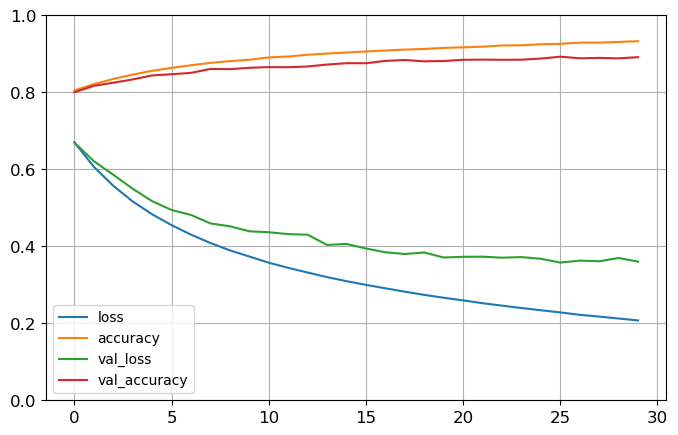

In [17]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()